In [6]:
from quantileRegression import quantileRegression

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import tables
import pandas as pd

In [7]:
qr_mc = quantileRegression("mc")

# This is what you want to correct
print "Load the mc dataframe"
startEvtmc = 0 
stopEvtmc  = 2000000

fname = 'df_mc_%d-%d.h5' % ( startEvtmc, stopEvtmc )
if os.path.exists(fname):
    qr_mc.df = pd.read_hdf(fname)
else:
    qr_mc.loadDF("../nt/double_ele_spring16v2_sync_v3_mc/",
            "cicNoSigmaIetaIeta/trees/",
                         ["DYToEE_powheg_13TeV_EBHighR9", "DYToEE_powheg_13TeV_EBLowR9", "DYToEE_powheg_13TeV_EEHighR9", "DYToEE_powheg_13TeV_EELowR9" ],
                          startEvtmc, stopEvtmc, 12345)

Load the mc dataframe


In [8]:
import ROOT as RT

In [9]:
RT.gROOT.LoadMacro("../phoIsoStoch/IsolationCorrection.C")

0

In [10]:
isoCorr = RT.IsolationCorrection("../phoIsoStoch/corrections_hybrid.root")

In [11]:
def applyCorr(row):
    rho,eta,iso = row['rho'],np.abs(row['ScEta']),row['PhoIso03']
    return iso+isoCorr.getExtra(eta,rho)

def applySample(row):
    rho,eta,iso = row['rho'],np.abs(row['ScEta']),row['PhoIso03']
    return isoCorr.getExtra(eta,rho,1,True)

qr_mc.df['PhoIso03_corr'] = qr_mc.df[['rho','ScEta','PhoIso03']].apply(applyCorr,axis=1)


In [12]:
qr_mc.df['PhoIso03_smpl'] = qr_mc.df[['rho','ScEta','PhoIso03']].apply(applySample,axis=1)

In [13]:
def applySampleBy(row,mult):
    rho,eta,iso = row['rho'],np.abs(row['ScEta']),row['PhoIso03']
    return isoCorr.getExtra(eta,rho,mult)

#qr_mc.df['PhoIso03_smpl1p4'] = qr_mc.df[['rho','ScEta','PhoIso03']].apply(lambda x: applySampleBy(x, 1.4),axis=1)
#qr_mc.df['PhoIso03_smpl1p5'] = qr_mc.df[['rho','ScEta','PhoIso03']].apply(lambda x: applySampleBy(x, 1.5),axis=1)

In [14]:
df = qr_mc.df

In [15]:
df['isEB'] = df[['ScEta']].apply(lambda x: (np.abs(x['ScEta']) < 1.5),axis=1).astype(np.bool)

In [16]:
df['isEB'].describe()

count     2000000
unique          2
top          True
freq      1665214
Name: isEB, dtype: object

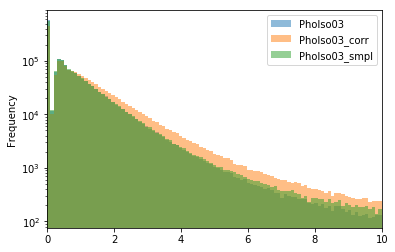

In [39]:
axEB = df[ df['isEB'] > 0 ][['PhoIso03','PhoIso03_corr','PhoIso03_smpl']].plot(kind='hist', xlim=(0,10),alpha=0.5,logy=True,bins=np.linspace(0,10,100))

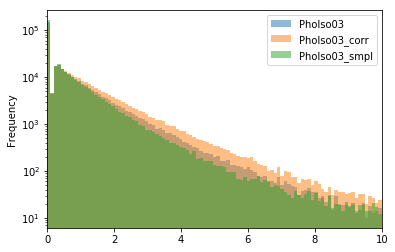

In [19]:
df[ df['isEB'] <= 0  ][['PhoIso03','PhoIso03_corr','PhoIso03_smpl']].plot(kind='hist', xlim=(0,10),alpha=0.5,logy=True,bins=np.linspace(0,10,100))

In [20]:
# Plot data, mc, mc_corrr
# just need to load the data for plotting 
qr_data = quantileRegression("data")
startEvtdata = 0
stopEvtdata   = -1
print "Load the data dataframe"

fname = 'df_data_%d-%d.h5' % ( startEvtdata, stopEvtdata )

if os.path.exists(fname):
    qr_data.df = pd.read_hdf(fname)
else:
    qr_data.loadDF("../nt/double_ele_spring16v2_sync_v3_ichep/",
                    "cicNoSigmaIetaIeta/trees/",
                    ["Data_13TeV_EBHighR9", "Data_13TeV_EBLowR9", "Data_13TeV_EEHighR9", "Data_13TeV_EELowR9" ],
                    startEvtdata, stopEvtdata)
df_data = qr_data.getDF()

Load the data dataframe


In [21]:
df_data['isEB'] = df_data[['ScEta']].apply(lambda x: (np.abs(x['ScEta']) < 1.5),axis=1).astype(np.bool)

In [22]:
def rho_data_mc(df_mc,df_data,bins):
    
    hist_mc_uncorr,_ = np.histogram(df_mc['rho'].values, density=True, bins=bins)

    hist_data,_ =  np.histogram(df_data['rho'].values, density=False, bins=bins)

    hist_mc_uncorr *= hist_data.sum()/hist_mc_uncorr.sum()    
    
    return hist_mc_uncorr,hist_data


        

In [23]:
def data_mc(df_mc,df_data,bins,var="PhoIso03",corrlabel="_corr"):
    
    hist_mc_uncorr,_ = np.histogram(df_mc[var].values, density=True, weights=df_mc['weight'].values, bins=bins)
    hist_mc_corr,_ = np.histogram(df_mc['%s%s' % (var,corrlabel) ].values, density=True, weights=df_mc['weight'].values, bins=bins)

    hist_data,_ =  np.histogram(df_data[var].values, density=False, bins=bins)

    hist_mc_uncorr *= hist_data.sum()/hist_mc_uncorr.sum()
    hist_mc_corr *= hist_data.sum()/hist_mc_corr.sum()
    
    
    return hist_mc_uncorr,hist_mc_corr,hist_data

In [24]:
def draw_data_mc(bins,corr,data,uncorr=None,figsize=(8,6),var=None,logy=False,ratio=False):
    
    binw=bins[1]-bins[0]
    if ratio:
        fig, axes = plt.subplots(2,figsize=figsize,sharex=True,gridspec_kw = {'height_ratios':[3, 1]})
        top = axes[0]
        bottom = axes[1]
    else:
        fig = plt.figure(figsize=figsize)
        axes = None
        top = plt
    fig.tight_layout()
    
    xc = bins[1:]-binw*0.5
    
    corr_label = 'MC'
    if uncorr != None:
        top.bar(xc,uncorr,width=binw,label='MC uncorr',alpha=0.5,color='red',linewidth=0.)
        corr_label += ' corr'
    top.bar(xc,corr,width=binw,label=corr_label,alpha=0.5,color='blue',linewidth=0.)
    top.errorbar( xc, data,ls='None', xerr=np.ones_like(data)*binw*0.5, yerr=np.sqrt(data), color='black', label='data' )
    
    if axes == None: axes = fig.axes
    
    if ratio:
        rdata = data / corr
        rdata_err = np.sqrt(data) / corr
        corr_color = 'black'
        if uncorr != None:
            rdatau = data / uncorr
            rdatau_err = np.sqrt(data) / uncorr
            bottom.errorbar( xc+binw*0.5, rdatau,ls='None', xerr=np.ones_like(rdatau)*binw*0.5, yerr=rdatau_err, 
                            color='red' )
            corr_color = 'blue'
        bottom.errorbar( xc, rdata,ls='None', xerr=np.ones_like(rdata)*binw*0.5, yerr=rdata_err, 
                        color=corr_color)
        
        bottom.plot( (bins[0],bins[-1]), (1,1), 'k-' )
        bottom.set_ylabel('Data / MC')
        bottom.set_ylim(0,2)
    
    if logy:
        axes[0].set_yscale('log')
    axes[0].set_xlim(bins[0],bins[-1])
    
    unit = None    
    if var != None:
        if type(var) != str:
            var, unit = var
        if unit: var += " (%s)" % unit
        axes[-1].set_xlabel(var)
    ylabel = 'Events / %1.3g' % binw
    if unit:
        ylabel += ' %s' % unit
    axes[0].set_ylabel(ylabel)

    top.legend(loc='best')

        

/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


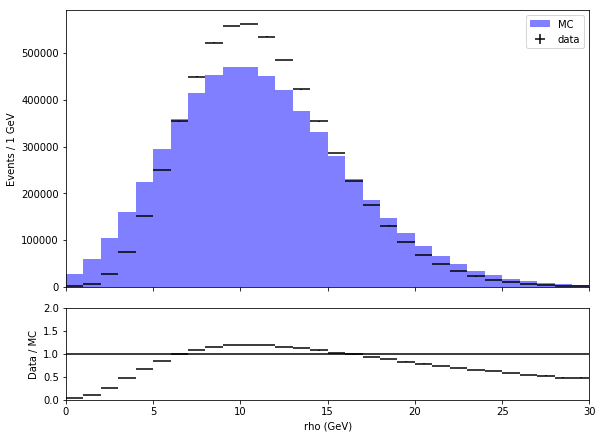

In [25]:
bins=np.linspace(0,30,31)

uncorr,data = rho_data_mc( df.query('isEB == 1'), 
                           df_data.query('isEB == 1'), bins  )


draw_data_mc(bins,uncorr,data,var=('rho','GeV'), logy=False, ratio=True)

In [26]:
rhobins = bins
weight = data / uncorr

np.where(rhobins<10)[0][-1]
rhobins[np.searchsorted(rhobins,2.5)]

3.0

In [27]:
def rewei(row):
    
    rho = row['rho']
    irho = np.searchsorted(rhobins,rho)
    if irho > 0: irho -= 1
    if irho >= weight.size: irho = -1
    return weight[irho]
    

In [28]:
qr_mc.df['weight'] = qr_mc.df[['rho']].apply(rewei,axis=1)

/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


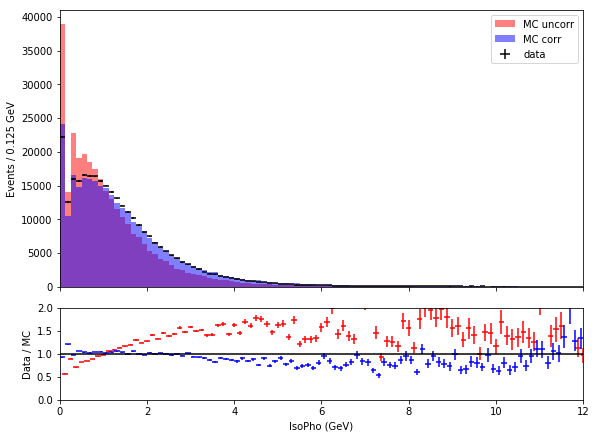

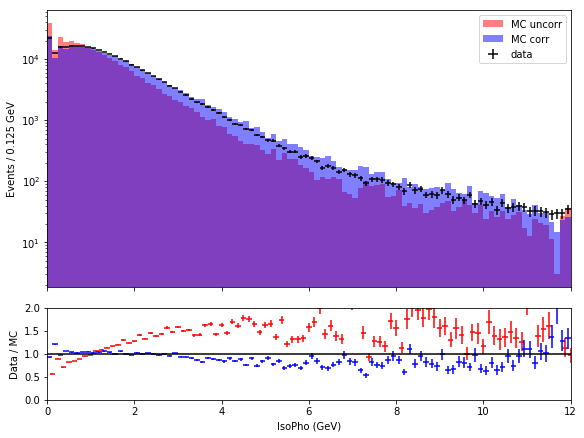

In [29]:
bins=np.linspace(0,12,97)

cut='isEB == 1 & mass > 60 & mass < 120 & rho >15 & ( ScEta < -1 | ScEta > 1) & (ScEta > -1.5 & ScEta < 1.5)'

uncorr,corr,data = data_mc( df.query(cut),
                                     #'& rho > 10  & rho < 15 & ScEta > -1.5 & ScEta < 1.5 & (ScEta < -1 | ScEta > 1)  '), 
                           df_data.query(cut),
                                    # 'isEB == 1 & mass > 60 & mass < 120 & rho > 10 & rho < 15  & ScEta > -1 & ScEta < 1'), 
                           bins, corrlabel="_corr"  )

draw_data_mc(bins,corr,data,uncorr,var=('IsoPho','GeV'), logy=False, ratio=True)
draw_data_mc(bins,corr,data,uncorr,var=('IsoPho','GeV'), logy=True, ratio=True)

/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


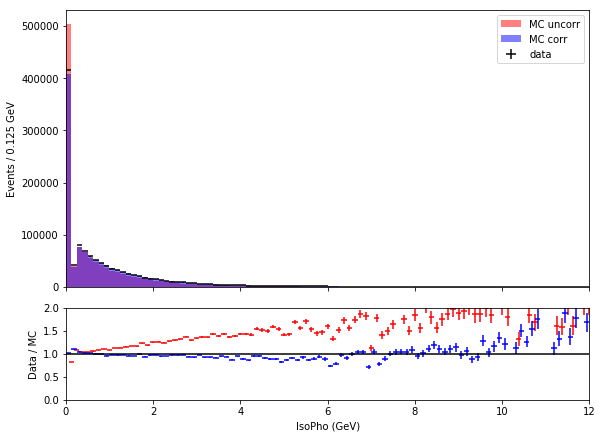

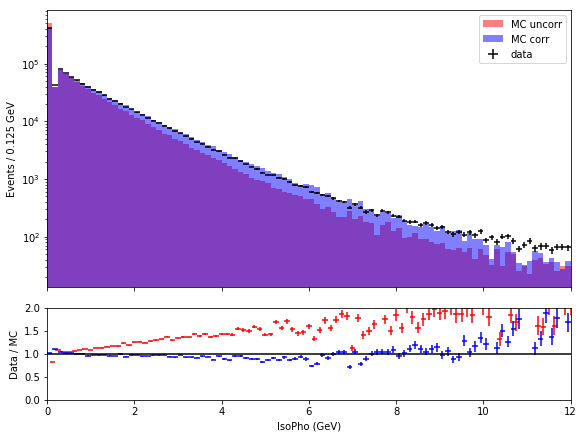

In [30]:
bins=np.linspace(0,12,97)

uncorr,corr,data = data_mc( df.query('isEB == 0  & mass > 60 & mass < 120'), 
                           df_data.query('isEB == 0  & mass > 60 & mass < 120'), bins  )

draw_data_mc(bins,corr,data,uncorr,var=('IsoPho','GeV'), logy=False, ratio=True)
draw_data_mc(bins,corr,data,uncorr,var=('IsoPho','GeV'), logy=True, ratio=True)

# |eta| min   |eta| max   effective area
0.0000         1.0000        0.1210   
1.0000         1.4790        0.1107
1.4790         2.0000        0.0699
2.0000         2.2000        0.1056
2.2000         2.3000        0.1457
2.3000         2.4000        0.1719
2.4000         5.0000        0.1998

In [31]:
import numpy as np

effareas = np.array([[0.0000, 0.1210],   
                     [1.0000, 0.1107],
                     [1.4790, 0.0699],
                     [2.0000, 0.1056],
                     [2.2000, 0.1457],
                     [2.3000, 0.1719],
                     [2.4000, 0.1998],])

import bisect
def effArea(eta):    
    ibin = min(effareas.shape[0]-1,bisect.bisect_left(effareas[:,0],eta))
    return effareas[ibin,1]


def rhoCorrPhoIso(row):
    #return max(row[0]-row[1]*effArea(np.abs(row[2])), 2.5)
    return row[0]-row[1]*effArea(np.abs(row[2]))



In [40]:
df['PhoIso03RhoCorr'] = df[['PhoIso03', 'rho','ScEta']].apply(rhoCorrPhoIso,axis=1,raw=True)
df['PhoIso03RhoCorr_corr'] = df[['PhoIso03_corr', 'rho','ScEta']].apply(rhoCorrPhoIso,axis=1,raw=True)

In [41]:
df_data['PhoIso03RhoCorr'] = df_data[['PhoIso03', 'rho','ScEta']].apply(rhoCorrPhoIso,axis=1,raw=True)

/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide
/mnt/t3nfs01/data01/sh

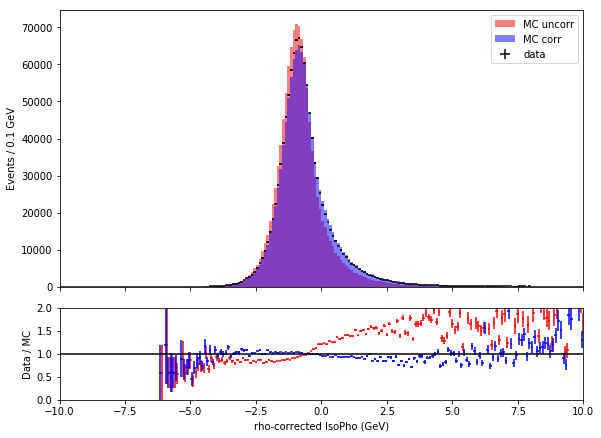

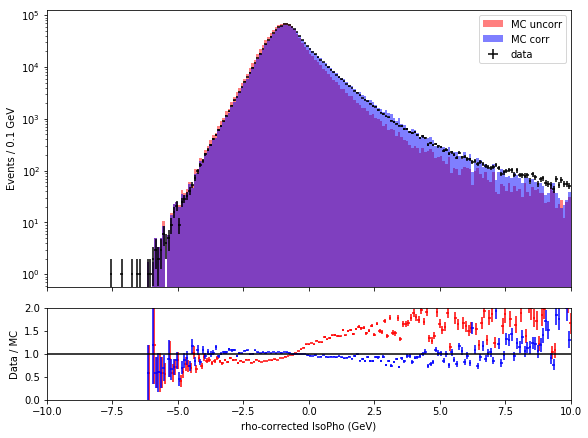

In [42]:
bins=np.linspace(-10,10,201)

uncorr,corr,data = data_mc( df.query('isEB == 0  & mass > 60 & mass < 120'), 
                           df_data.query('isEB == 0  & mass > 60 & mass < 120'), bins, var='PhoIso03RhoCorr'  )

draw_data_mc(bins,corr,data,uncorr,var=('rho-corrected IsoPho','GeV'), logy=False, ratio=True)
draw_data_mc(bins,corr,data,uncorr,var=('rho-corrected IsoPho','GeV'), logy=True, ratio=True)

/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide
/mnt/t3nfs01/data01/shome/musella/.local/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide
/mnt/t3nfs01/data01/sh

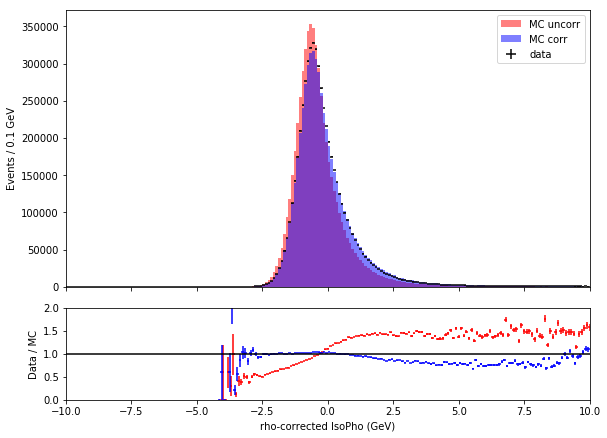

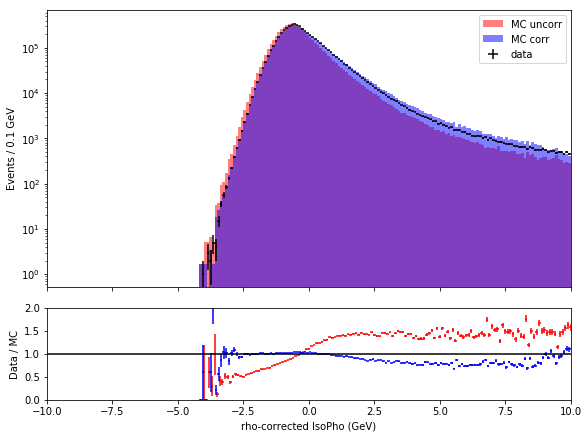

In [43]:
bins=np.linspace(-10,10,201)

uncorr,corr,data = data_mc( df.query('isEB == 1  & mass > 60 & mass < 120'), 
                           df_data.query('isEB == 1  & mass > 60 & mass < 120'), bins, var='PhoIso03RhoCorr'  )

draw_data_mc(bins,corr,data,uncorr,var=('rho-corrected IsoPho','GeV'), logy=False, ratio=True)
draw_data_mc(bins,corr,data,uncorr,var=('rho-corrected IsoPho','GeV'), logy=True, ratio=True)